In [3]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd

## Creating the dataset

In [4]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [5]:
base_path = Path('../input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

8400

In [6]:
x, y = data[1000]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

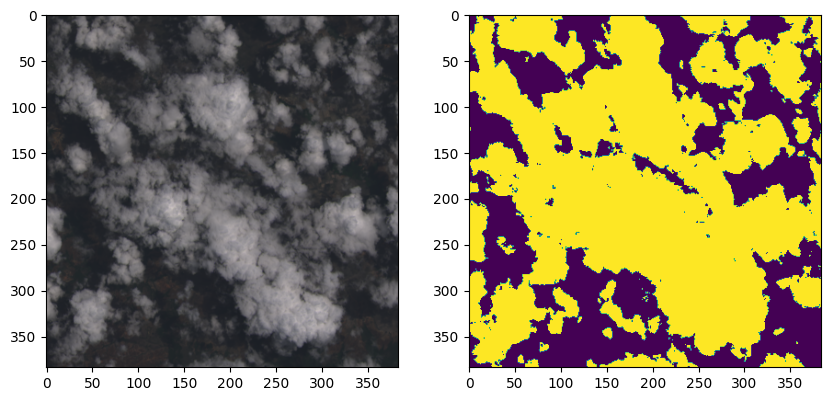

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(185))
ax[1].imshow(data.open_mask(185))

In [8]:
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))

In [9]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=8, shuffle=True)

In [10]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([8, 4, 384, 384]), torch.Size([8, 384, 384]))

# The model

In [15]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand


In [16]:
unet = UNET(4,2)

In [14]:
# testing one pass
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([8, 4, 384, 384]), torch.Size([8, 384, 384]))

In [15]:
pred = unet(xb)
pred.shape

torch.Size([8, 2, 384, 384])

In [16]:
import time
import gc
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))

                # clear the cache and unused variables/tensors
                torch.cuda.empty_cache()
                del x
                del y
                del outputs
                del acc
                gc.collect()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()


In [17]:
def dice_loss(outputs, targets, smooth=1):
    num_classes = outputs.size(1)
    targets = targets.unsqueeze(1)
    targets_one_hot = torch.zeros_like(outputs)
    targets_one_hot.scatter_(1, targets, 1)

    outputs = outputs.view(-1)
    targets_one_hot = targets_one_hot.view(-1)

    intersection = (outputs * targets_one_hot).sum()
    dice = (2. * intersection + smooth) / (outputs.sum() + targets_one_hot.sum() + smooth)

    return 1 - dice

In [19]:
loss_fn = dice_loss
opt = torch.optim.Adam(unet.parameters(), lr=0.01)
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=40)

Epoch 39/39
----------
valid Loss: -2.9499 Acc: 0.6801053285598755
----------
Training complete in 371m 17s


In [22]:
torch.save(unet, 'trained_model.pth')

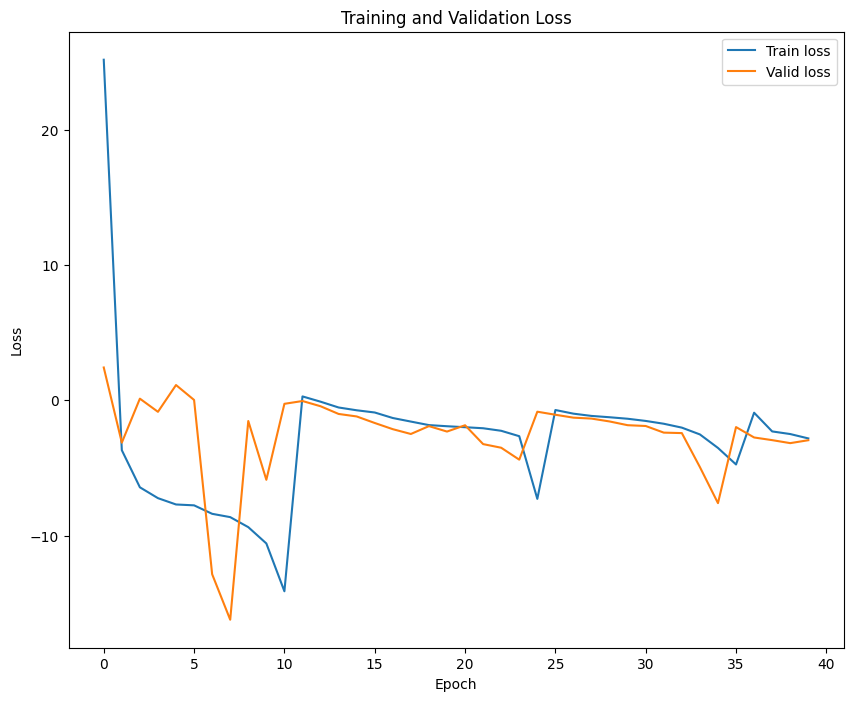

In [40]:
import matplotlib.pyplot as plt

# Move the tensors to CPU and convert to NumPy arrays
train_loss_cpu = [loss.cpu().item() for loss in train_loss]
valid_loss_cpu = [loss.cpu().item() for loss in valid_loss]

# Plot the training and validation loss
plt.figure(figsize=(10, 8))
plt.plot(train_loss_cpu, label='Train loss')
plt.plot(valid_loss_cpu, label='Valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()


In [58]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [59]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = unet(xb.cuda())

predb.shape

torch.Size([8, 2, 384, 384])

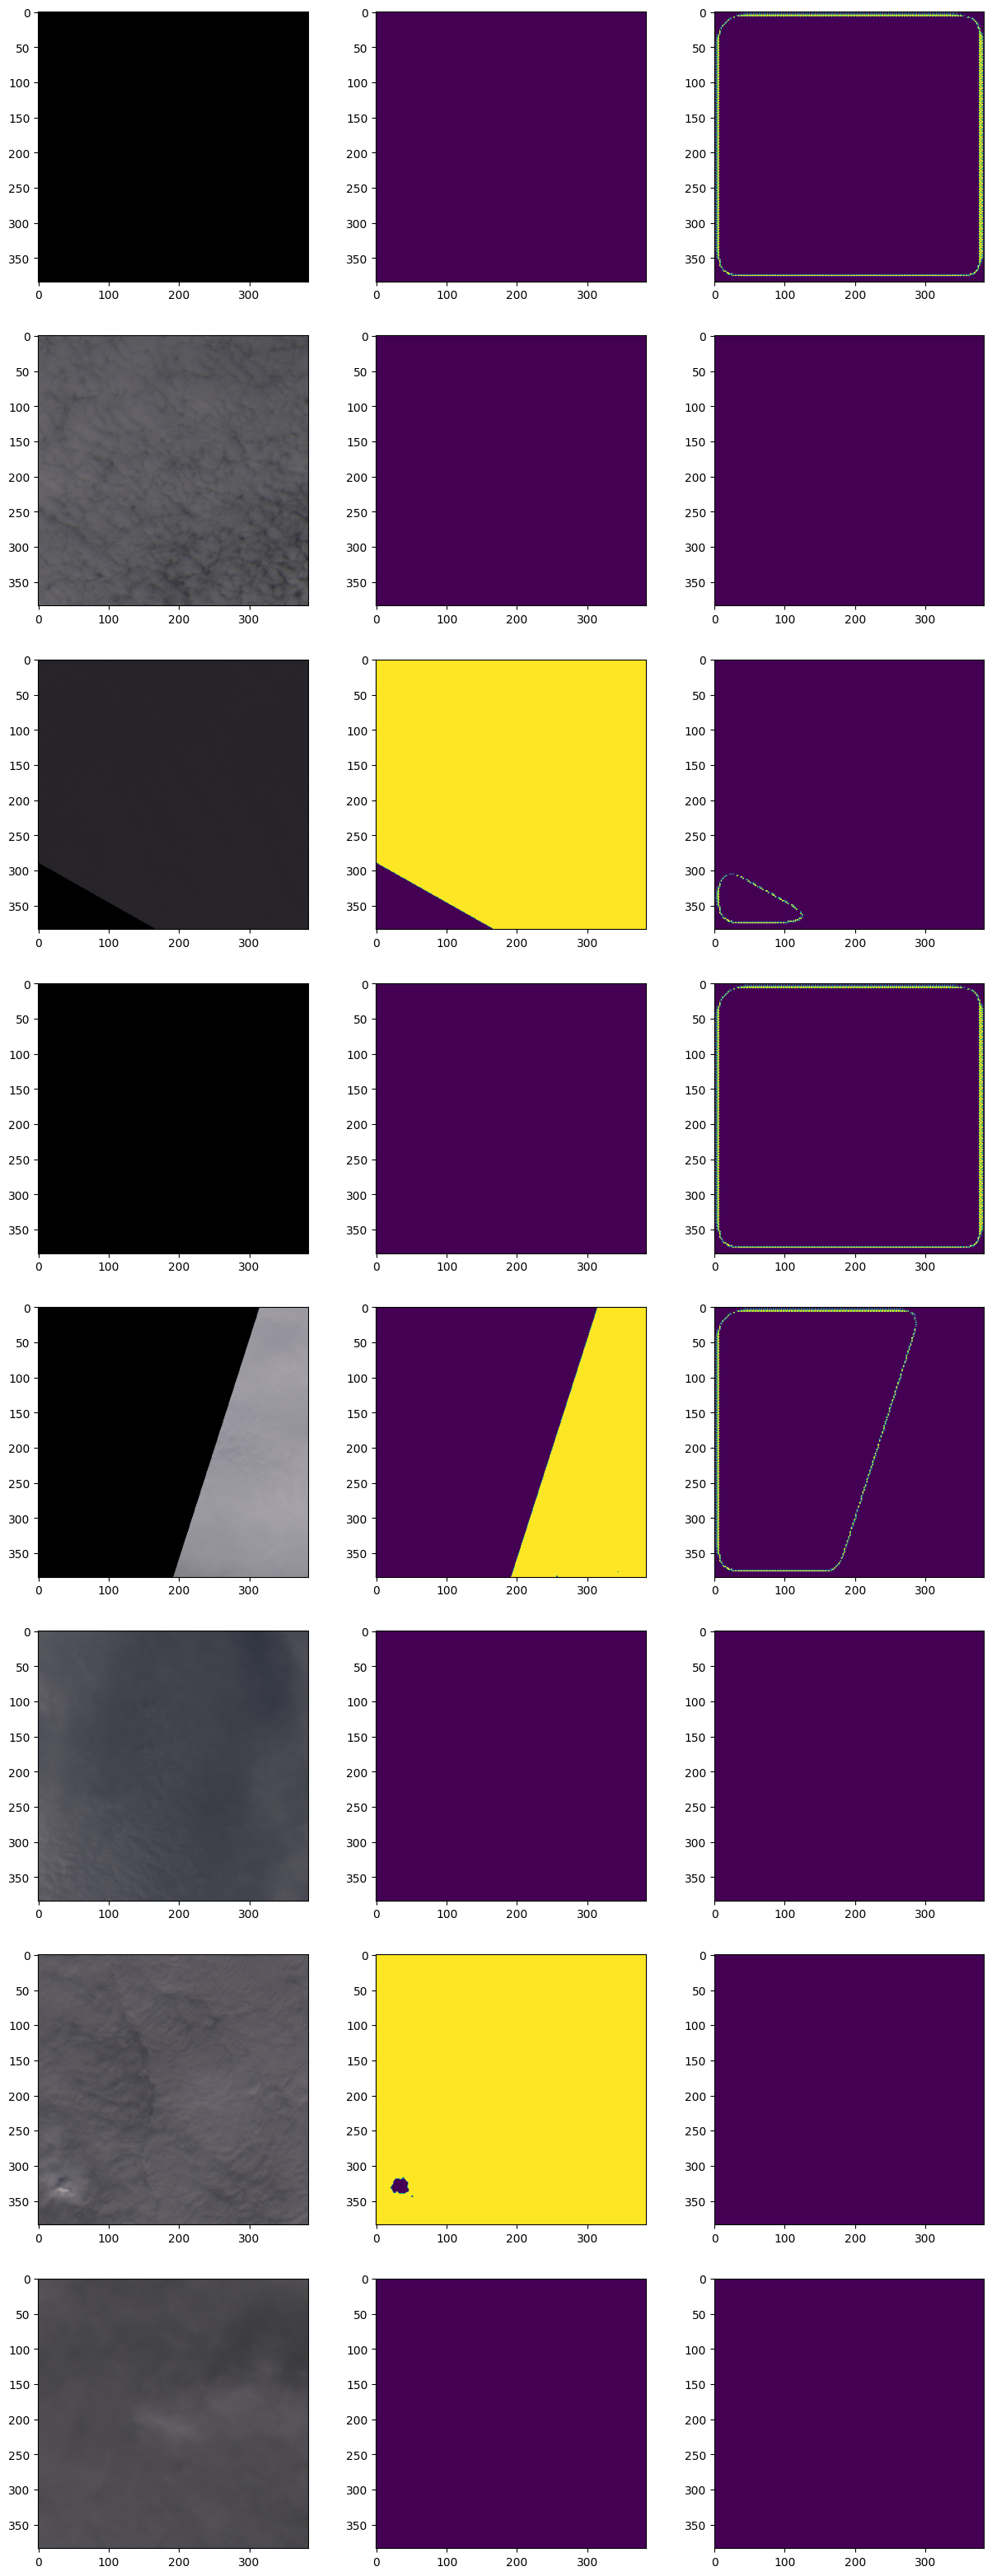

In [60]:
bs = 8
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))


In [12]:
class testDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir')}

        return files
                                       
    def __len__(self):
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        return x

test_path = Path('/kaggle/input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_test')
test_ds = testDataset(test_path/'test_red', 
                      test_path/'test_green', 
                      test_path/'test_blue', 
                      test_path/'test_nir')

test_dl = DataLoader(test_ds, batch_size=6, shuffle=False)



In [ ]:
def test(model, test_dl):
    model.eval()
    model.cuda()
    
    predictions = []
    for x in test_dl:
        x = x.cuda()
        with torch.no_grad():
            outputs = model(x)
            pred = torch.argmax(outputs, dim=1)
        predictions.append(pred.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    return predictions

# Perform testing
predictions = test(unet, test_dl)

# Visualize the test results
bs = 12
fig, ax = plt.subplots(bs, 2, figsize=(10, bs*5))
for i in range(bs):
    ax[i, 0].imshow(test_ds.open_as_pil(i))
    ax[i, 1].imshow(predictions[i])


In [19]:
def test(model, test_dl, memory_threshold=100):
    model.eval()
    model.cuda()

    predictions = []
    for i, x in enumerate(test_dl):
        x = x.cuda()
        with torch.no_grad():
            outputs = model(x)
            pred = torch.argmax(outputs, dim=1)
        predictions.append(pred.cpu().numpy())
        
        if (i + 1) % int(len(test_dl) / 10) == 0:
            torch.cuda.empty_cache()
            
        if torch.cuda.memory_allocated() / 1024 / 1024 > memory_threshold:
            torch.cuda.empty_cache()
        
    predictions = np.concatenate(predictions, axis=0)
    return predictions

# Use only 10% of the test data
num_samples = int(len(test_ds) * 0.1)
test_subset = torch.utils.data.Subset(test_ds, range(num_samples))
test_dl = DataLoader(test_subset, batch_size=6, shuffle=False)

# Perform testing
predictions = test(unet, test_dl, memory_threshold=100)